In [1]:
import sys
sys.path.append("../../src")
from constants import AMINO_ACID_INDICES, IMMUNOGENICITY_ONE_HOT
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def vectorize(data):
    dataset_aa_indices = []
    for aa_sequence in data:
        aa_sequence_indices = []
        for aa in aa_sequence:
            aa_sequence_indices.append(AMINO_ACID_INDICES[aa])
        dataset_aa_indices.append(aa_sequence_indices)
    dataset_aa_indices = np.array(dataset_aa_indices)
    return dataset_aa_indices

def one_hot_sequence(sequence):
    return np.eye(21)[sequence].flatten()

# Prepare training data

In [4]:
with open("../../datasets/spikeprot_train.txt", "r") as f:
    train = f.read().splitlines()

In [5]:
train_sequences = {}
for sequence in train:
    if sequence not in train_sequences:
        train_sequences[sequence] = 0
    train_sequences[sequence] += 1

train_ids = vectorize(list(train_sequences.keys()))
train_one_hot = np.apply_along_axis(one_hot_sequence, 1, train_ids)

In [6]:
train_one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
pca = PCA(n_components=2)
train_pc = pca.fit_transform(train_one_hot)

# Prepare Vaxformer sequences

In [10]:
from Bio import SeqIO

In [13]:
vaxformer_sequence_filepaths = [
    "../../sample_outputs/2023_03_17__15_35_04/vaxformer__high__full.fasta",
    "../../sample_outputs/2023_03_17__15_35_04/vaxformer__intermediate__full.fasta",
    "../../sample_outputs/2023_03_17__15_35_04/vaxformer__low__full.fasta",
]

vaxformer_sequences = {}
for sequence_filepath in vaxformer_sequence_filepaths:
    for record in SeqIO.parse(sequence_filepath, "fasta"):
        vaxformer_sequences.update({str(record.seq): int(record.id)})

vaxformer_ids = vectorize(list(vaxformer_sequences.keys()))
vaxformer_one_hot = np.apply_along_axis(one_hot_sequence, 1, vaxformer_ids)

vaxformer_pc = pca.transform(vaxformer_one_hot)

# Prepare LSTM sequences

In [15]:
lstm_sequence_filepaths = [
    "../../sample_outputs/2023_03_21__14_22_17/lstm_base__high__full.fasta",
    "../../sample_outputs/2023_03_21__14_22_17/lstm_base__intermediate__full.fasta",
    "../../sample_outputs/2023_03_21__14_22_17/lstm_base__low__full.fasta",
]

lstm_sequences = {}
for sequence_filepath in lstm_sequence_filepaths:
    for record in SeqIO.parse(sequence_filepath, "fasta"):
        lstm_sequences.update({str(record.seq): int(record.id)})

lstm_ids = vectorize(list(lstm_sequences.keys()))
lstm_one_hot = np.apply_along_axis(one_hot_sequence, 1, lstm_ids)

lstm_pc = pca.transform(lstm_one_hot)

# Prepare VAE sequences

In [16]:
vae_sequence_filepaths = [
    "../../sample_outputs/phillipsetal_2022/FC_004_gen_high_all.fasta",
    "../../sample_outputs/phillipsetal_2022/FC_004_gen_low_all.fasta",
    "../../sample_outputs/phillipsetal_2022/FC_004_gen_medium_all.fasta",
]

vae_sequences = {}
for sequence_filepath in vae_sequence_filepaths:
    for record in SeqIO.parse(sequence_filepath, "fasta"):
        vae_sequences.update({str(record.seq): int(record.id)})

vae_ids = vectorize(list(vae_sequences.keys()))
vae_one_hot = np.apply_along_axis(one_hot_sequence, 1, vae_ids)

vae_pc = pca.transform(vae_one_hot)

# Prepare Naive Bayes sequences

In [17]:
naive_bayes_sequence_filepaths = [
    "../../sample_outputs/2023_03_22__18_07_24/naive_bayes__full.fasta",
]

naive_bayes_sequences = {}
for sequence_filepath in naive_bayes_sequence_filepaths:
    for record in SeqIO.parse(sequence_filepath, "fasta"):
        naive_bayes_sequences.update({str(record.seq): int(record.id)})

naive_bayes_ids = vectorize(list(naive_bayes_sequences.keys()))
naive_bayes_one_hot = np.apply_along_axis(one_hot_sequence, 1, naive_bayes_ids)

naive_bayes_pc = pca.transform(naive_bayes_one_hot)

In [31]:
import pandas as pd

pcs = np.concatenate((train_pc, vaxformer_pc, lstm_pc, vae_pc, naive_bayes_pc))

df = pd.DataFrame(pcs, columns = ["PC1", "PC2"])
df["labels"] = ["Natural"] * len(train_pc) + ["Vaxformer"] * len(vaxformer_pc) + ["LSTM"] * len(lstm_pc) + ["VAE"] * len(vae_pc) + ["Naive Bayes"] * len(naive_bayes_pc)
df["counts"] = list(train_sequences.values()) + list(vaxformer_sequences.values()) + list(lstm_sequences.values()) + list(vae_sequences.values()) + list(naive_bayes_sequences.values())

In [112]:
df_filtered = pd.concat([df.loc[df["labels"] == "Natural"], df.loc[df["labels"] != "Natural"].sort_values(["counts"], ascending=False).groupby("labels").head(2000)])

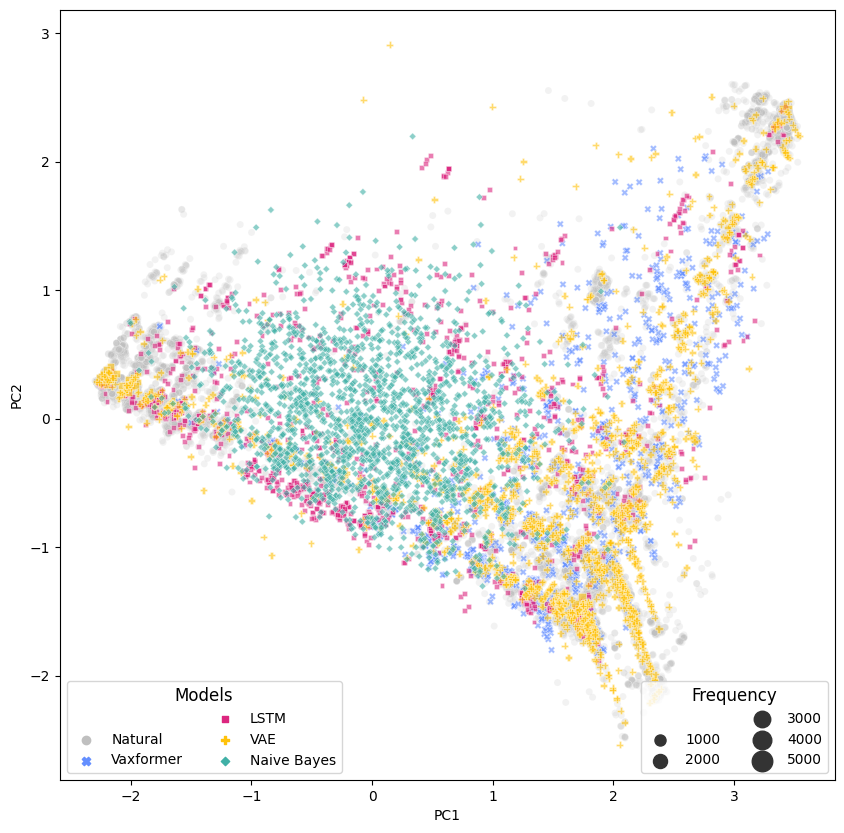

In [114]:
# sns.scatterplot(df, x="PC1", y="PC2", hue="labels", size="counts")

plt.rcParams["figure.figsize"] = [10, 10]

df_filtered["labels"] = pd.Categorical(df_filtered["labels"], categories=["Natural", "Vaxformer", "LSTM", "VAE", "Naive Bayes"], ordered=True)

# Sort the DataFrame by the categorical variable
df_filtered = df_filtered.sort_values("labels")

custom_palette = sns.color_palette(["#BFBFBF", "#648FFF", "#DC267F", "#FFC20A", "#40B0A6"])
transparency = [0.2] * sum(df_filtered["labels"] == "Natural") + [0.6] * sum(df_filtered["labels"] != "Natural")

axes = sns.scatterplot(df_filtered, x="PC1", y="PC2", hue="labels", style="labels", size="counts", sizes=(25, 250), palette=custom_palette, alpha=transparency)

h,l = axes.get_legend_handles_labels()
l1 = axes.legend(h[:int(len(h)/2)],l[:int(len(l)/2)], loc="lower left", ncol=2, title_fontsize="large")
l2 = axes.legend(h[int(len(h)/2):],l[int(len(l)/2):], loc="lower right", ncol=2, title_fontsize="large")

l1.set_title("Models")
l2.set_title("Frequency")

for text in l1.texts:
    if text.get_text() == "labels":
        text.set_text("")
        break
        
for text in l2.texts:
    if text.get_text() == "counts":
        text.set_text("")
        break

axes.add_artist(l1)